# <center> eXtreme Gradient Boosting
### train, evaluate, plot feature importance and visualize log loss

## <font color = 'blue'> Get the data

In [2]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.externals import joblib
from sklearn.metrics import precision_score
from sklearn import cross_validation, metrics
from time import time
import pandas as pd
import collections
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[ 0.10924883,  1.83030605, -0.14807631, ...
X_32_val                  -> array([[ 0.66944195,  0.46536115,  0.79919788, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.6694419
X_32train_std             -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -6.40490
X_test_new                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_train                   -> array([[[ 0.00119031,  0.00873315,  0.00641749, ..
X_train_new               -> array([[-0.74031227,  0.23616372, -0.18182195, ...
X_train_std               -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([6, 6, 5, ..., 0, 4, 1])
y_32_test          

In [3]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## <font color = 'blue'> Train and test

In [7]:
def train_and_test(model, train_data=X_32train_std, train_labels=y_32_train, test_data=X_32test_std, test_labels=y_32_test):
    
    dtrain = xgb.DMatrix(train_data, label=train_labels)
    dtest = defaultdict(list)
    for snr in snrs:
        dtest[snr] = xgb.DMatrix(test_data[snr], label=test_labels[snr])
    parameters = model.get_xgb_params()
    
    eval_history = xgb.cv(parameters, dtrain, metrics = 'mlogloss', nfold = 5, early_stopping_rounds = 20,
                         num_boost_round = model.get_params()['n_estimators'])
    model.set_params(n_estimators = eval_history.shape[0])
    
    eval_set = [(train_data, train_labels), (test_data[10], test_labels[10])]
    start = time()
    model.fit(train_data, train_labels, eval_metric = 'mlogloss', eval_set = eval_set) #fit model to data
    print("Fitting model to data took {} minutes".format((time() - start)/60))
    
    # Compute metric for training data
    train_predict = model.predict(train_data)
    train_predict_prob = model.predict_proba(train_data)
    print("Log loss on training set =", metrics.log_loss(train_labels, train_predict_prob))
    
    # Compute metric for test data
    test_logloss = []
    for snr in snrs:
        test_predict = model.predict(test_data[snr])
        test_predict_prob = model.predict_proba(test_data[snr])
        loss = metrics.log_loss(test_labels[snr], test_predict_prob)
        test_logloss.append(loss)
    print("Log loss on test set =", np.mean(test_logloss))
    
    return model

In [8]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=2,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        num_class = 8,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
model = train_and_test(xgb1)

[0]	validation_0-mlogloss:1.95137	validation_1-mlogloss:1.81709
[1]	validation_0-mlogloss:1.85664	validation_1-mlogloss:1.62606
Fitting model to data took 0.0342695156733195 minutes
Log loss on training set = 1.85664015828
Log loss on test set = 1.85786188921


## Accuracy vs. SNR on test set

In [10]:
predictions = defaultdict(list)
accuracy = defaultdict(list)
y_pred = defaultdict(list)
# for snr in snrs:
#     predictions[snr] = model.predict(X_test_std[snr])
#     y_pred[snr] = np.asarray([np.argmax(line) for line in predictions[snr]])
#     accuracy[snr] = metrics.accuracy_score(y_test[snr], y_pred[snr])
#     print ("Test accuracy at ",snr,"dB =", accuracy[snr])
   
for snr in snrs:
    y_pred[snr] = model.predict(X_32test_std[snr])
    predictions[snr] = [round(value) for value in y_pred[snr]]
    accuracy[snr] = accuracy_score(y_32_test[snr], predictions[snr])
    print ("Test accuracy at ",snr,"dB =", accuracy[snr])

Test accuracy at  -20 dB = 0.12725
Test accuracy at  -18 dB = 0.12275
Test accuracy at  -16 dB = 0.131
Test accuracy at  -14 dB = 0.12425
Test accuracy at  -12 dB = 0.13725
Test accuracy at  -10 dB = 0.17675
Test accuracy at  -8 dB = 0.2375
Test accuracy at  -6 dB = 0.307
Test accuracy at  -4 dB = 0.3955
Test accuracy at  -2 dB = 0.38125
Test accuracy at  0 dB = 0.43425
Test accuracy at  2 dB = 0.521
Test accuracy at  4 dB = 0.7525
Test accuracy at  6 dB = 0.811
Test accuracy at  8 dB = 0.8075
Test accuracy at  10 dB = 0.82575
Test accuracy at  12 dB = 0.83225
Test accuracy at  14 dB = 0.84325
Test accuracy at  16 dB = 0.82975
Test accuracy at  18 dB = 0.83625


## Importance score

In [12]:
feature_names = ['f'+str(i) for i in range(1,33)]
print("Feature importance scores- highest first")
df1 = pd.DataFrame(data = {'Features':feature_names, 'Importance Scores': model.feature_importances_})
sorted_df = df1.sort_values(by = ['Importance Scores'], ascending = False)
sorted_df.reset_index(inplace = True)
del sorted_df['index']
sorted_df

Feature importance scores- highest first


,Features,Importance Scores
0,f5,0.149220
1,f14,0.124722
2,f13,0.104677
3,f6,0.102450
4,f1,0.091314
5,f21,0.075724
6,f17,0.040089
7,f29,0.037862
8,f18,0.037862
9,f30,0.028953


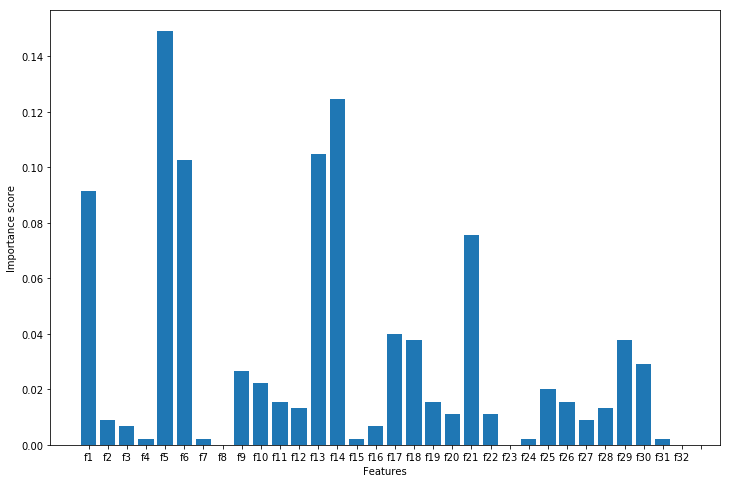

Scores using XGBoost's function:


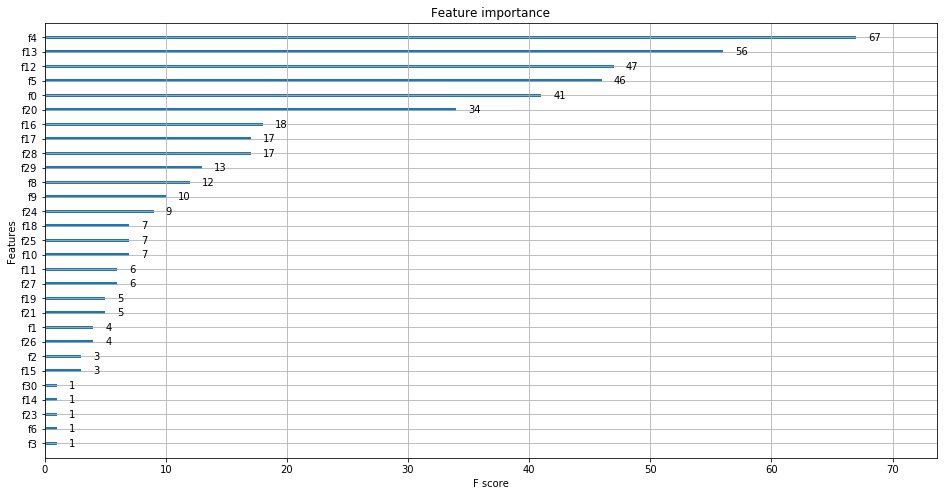

In [28]:
%matplotlib inline
plt.figure(figsize = (12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xlabel("Features")
plt.xticks(np.arange(X_32train_std.shape[1]+1), feature_names)
plt.ylabel("Importance score")
plt.show()
print("Scores using XGBoost's function:")

xgb.plot_importance(model, ylabel = 'Features')
fig = plt.gcf()
fig.set_size_inches(16,8)

## Feature Selection

In [29]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds

array([ 0.        ,  0.        ,  0.        ,  0.00222717,  0.00222717,
        0.00222717,  0.00222717,  0.00222717,  0.00668151,  0.00668151,
        0.00890869,  0.00890869,  0.01113586,  0.01113586,  0.01336303,
        0.01336303,  0.0155902 ,  0.0155902 ,  0.0155902 ,  0.02004454,
        0.02227172,  0.02672606,  0.02895323,  0.03786192,  0.03786192,
        0.04008909,  0.07572383,  0.09131403,  0.10244989,  0.10467706,
        0.1247216 ,  0.1492205 ], dtype=float32)

## On training set

In [30]:
train_accs = []
num_features = []
thresh_vals = []

for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    #selecting features based on importance weights
    #features whose importance is >= thresh are kept, and the remaining discarded
    
    select_X_train = selection.transform(X_32train_std)
    n_features = select_X_train.shape[1]
    print("Top {} features selected".format(n_features))
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    #Evaluate model on training set
    y_pred = selection_model.predict(select_X_train)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_32_train, predictions)
    print("Thresh=%.3f, n_features=%d, Accuracy: %.2f%%" % (thresh, n_features, accuracy*100.0))
    print("  ")
    train_accs.append(accuracy)
    num_features.append(n_features)
    thresh_vals.append(thresh)

Top 32 features selected
Thresh=0.000, n_features=32, Accuracy: 52.23%
  
Top 32 features selected
Thresh=0.000, n_features=32, Accuracy: 52.23%
  
Top 32 features selected
Thresh=0.000, n_features=32, Accuracy: 52.23%
  
Top 29 features selected
Thresh=0.002, n_features=29, Accuracy: 52.23%
  
Top 29 features selected
Thresh=0.002, n_features=29, Accuracy: 52.23%
  
Top 29 features selected
Thresh=0.002, n_features=29, Accuracy: 52.23%
  
Top 29 features selected
Thresh=0.002, n_features=29, Accuracy: 52.23%
  
Top 29 features selected
Thresh=0.002, n_features=29, Accuracy: 52.23%
  
Top 24 features selected
Thresh=0.007, n_features=24, Accuracy: 52.32%
  
Top 24 features selected
Thresh=0.007, n_features=24, Accuracy: 52.32%
  
Top 22 features selected
Thresh=0.009, n_features=22, Accuracy: 52.27%
  
Top 22 features selected
Thresh=0.009, n_features=22, Accuracy: 52.27%
  
Top 20 features selected
Thresh=0.011, n_features=20, Accuracy: 52.28%
  
Top 20 features selected
Thresh=0.011,

In [33]:
df = pd.DataFrame(data= {'Threshold':thresh_vals,'n_features':num_features, 'Training accuracy':train_accs})
sorted_df = df.sort_values(by = ['Training accuracy'], ascending = False)
sorted_df.reset_index()
print(sorted_df)
sorted_df.reset_index(inplace = True) #reset because sorting messed up the indices
idx = sorted_df['Training accuracy'].idxmax()
sel_row= sorted_df.iloc[idx]
best_features = int(sel_row['n_features'])
best_thresh = sel_row['Threshold']
print('Best training accuracy is obtained upon selection of top {} features (according to importance score)'.format(best_features))
print("The corresponding threshold value is {}".format(best_thresh))

    Threshold  Training accuracy  n_features
8    0.006682           0.523238          24
9    0.006682           0.523238          24
13   0.011136           0.522763          20
12   0.011136           0.522763          20
11   0.008909           0.522663          22
10   0.008909           0.522663          22
15   0.013363           0.522500          18
14   0.013363           0.522500          18
0    0.000000           0.522312          32
7    0.002227           0.522312          29
6    0.002227           0.522312          29
5    0.002227           0.522312          29
4    0.002227           0.522312          29
3    0.002227           0.522312          29
2    0.000000           0.522312          32
1    0.000000           0.522312          32
18   0.015590           0.520338          16
16   0.015590           0.520338          16
17   0.015590           0.520338          16
21   0.026726           0.520188          11
22   0.028953           0.519737          10
19   0.020

## Modify training and test data to include only selected features

In [34]:
X_32test_new = defaultdict(list)

selection = SelectFromModel(model, threshold = best_thresh, prefit=True)

X_32train_new  = selection.transform(X_32train_std)
n_features = select_X_train.shape[1]
print("Top {} features selected".format(best_features))
print("New training set {} and labels {}".format(X_32train_new.shape, y_32_train.shape))

for snr in snrs:
    X_32test_new[snr] = selection.transform(X_32test_std[snr])
print("New test set {} and labels {} for each SNR value".format(X_32test_new[10].shape, y_32_test[10].shape))

Top 24 features selected
New training set (80000, 24) and labels (80000,)
New test set (4000, 24) and labels (4000,) for each SNR value


## Store the new training and test sets in Jupyter's db

In [35]:
%store X_32train_new
%store X_32test_new
%store

Stored 'X_32train_new' (ndarray)
Stored 'X_32test_new' (defaultdict)
Stored variables and their in-db values:
X_16_val                  -> array([[ 0.10924883,  1.83030605, -0.14807631, ...
X_32_val                  -> array([[ 0.66944195,  0.46536115,  0.79919788, ...
X_32test_new              -> defaultdict(<class 'list'>, {0: array([[ 0.6694419
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.6694419
X_32train_new             -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
X_32train_std             -> array([[-0.74031227,  0.0126481 , -0.30967801, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[ -6.40490
X_test_new                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.1092488
X_train                   -> array([[[ 0.00119031,  0.00873315,  0.00641749, ..
X_train_new               -> array([[-0.74031227,  0.23616372, -0.18182195, ...
X_train_st